<a href="https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/C2W2_GAN_Debiasing_(Optional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using GANs to augment and de-bias datasets

*Please note that this is an optional notebook that is meant to introduce more advanced concepts, if you're up for a challenge. So, don't worry if you don't completely follow every step!*

[*Fair Attribute Classification through Latent Space De-biasing*](https://princetonvisualai.github.io/gan-debiasing/). Vikram V. Ramaswamy, Sunnie S. Y. Kim, Olga Russakovsky. CVPR 2021.

### Goals

Fairness in visual recognition is becoming a prominent and critical topic of discussion as recognition systems are deployed at scale in the real world. Models trained from data in which target labels are correlated with protected attributes (i.e. gender, race) are known to learn and perpetuate those correlations. 

In this notebook, you will learn about *Fair Attribute Classification through Latent Space De-biasing* (Ramaswamy et al. 2020) that introduces a method for training accurate target classifiers while mitigating biases that stem from these correlations. Specifically, this work uses GANs to generate realistic-looking images and perturb these images in the underlying latent space to generate training data that is balanced for each protected attribute. They augment the original dataset with this perturbed generated data, and empirically demonstrate that target classifiers trained on the augmented dataset exhibit a number of both quantitative and qualitative benefits. 


## Problem

Suppose you want to train a visual recognition model that recognizes the presence of an attribute, such as **wearing a hat**. However, in the real world, wearing a hat can be correlated with **wearing glasses**, for example, because people often wear both hats and sunglasses outside and take them off inside. This correlation may be reflected in the training data, and a classifier trained to recognize a hat may rely on the presence of glasses. Consequently, the classifier may fail to recognize a hat in the absence of glasses, and vice versa.


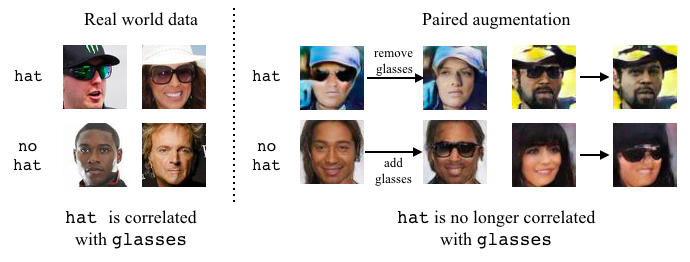





Ramaswamy et al. propose using a GAN to generate more images with hats but not glasses and images with glasses but not hats, such that **wearing a hat** is de-correlated from **wearing glasses** in the training data, by making perturbations in the latent space. Building on work by [Denton et al. (2019)](https://arxiv.org/abs/1906.06439), which demonstrates a method for learning interpretable image manipulation directions, they propose an improved latent vector perturbation method that allows you to preserve the **wearing a hat** attribute while changing the **wearing glasses** attribute. 

## Perturbing GAN latent vectors

Suppose a class of problems where a protected attribute is correlated with a target label in the data $\mathcal{X}$, influencing target label prediction. Let $t$ be the target label (e.g., **wearing a hat**) and $g$ be the protected attribute (e.g., **wearing glasses**) with $t,g\in\{-1,1\}$. To mitigate the effect of unwanted dataset bias, you'd want generate a balanced set of synthetic images $\mathcal{X_\textit{syn}}$ where the protected attribute and target label are de-correlated.

Concretely, let $f_t$ be a function from images to binary labels that approximates the target label $t$, and $f_g$ be a function from images to binary labels that approximates the protected attribute $g$. They learn these classifiers, $f_t$ and $f_g$, in a supervised fashion with the original data $\mathcal{X}$. The synthetic dataset $\mathcal{X_\textit{syn}}$ should have the property that for $\mathbf{x} \in \mathcal{X_\textit{syn}}$:

$$P\left[{f_t}(\mathbf{x}) = 1 | {f_g}(\mathbf{x}) = 1 \right] = P\left[{f_t}(\mathbf{x}) =1   \right],$$

such that attributes $t$ and $g$ are de-correlated. 

$\mathcal{X_\textit{syn}}$ can be generated with GAN trained on $\mathcal{X}$, whose generator $G$ generates a synthetic image $\mathbf{x}$ from a random latent vector $\mathbf{z} \in \mathcal{Z}$. Then, ${f_t}(\mathbf{x})$ and ${f_g}(\mathbf{x})$ can be trained to assign semantic attribute labels to these images and augment the real-world dataset. However, as the GAN inherits correlations from its training data, a random sampling of $\mathbf{z}$ will produce a $\mathcal{X_\textit{syn}}$ with similar correlations and biases as $\mathcal{X}$. To get around this, the authors propose a latent vector perturbation method that allows generation of a de-biased $\mathcal{X_\textit{syn}}$.

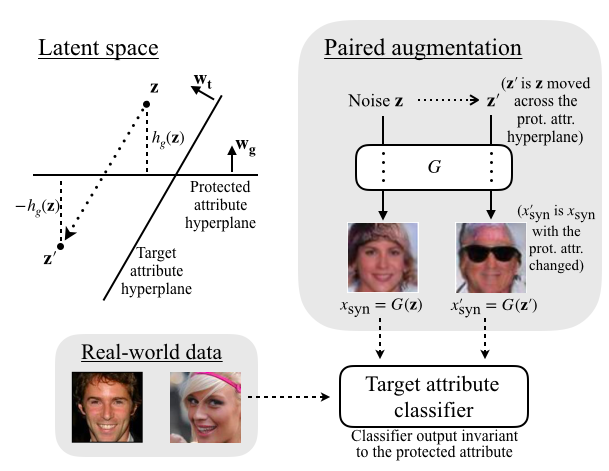

The approach is motivated by the assumption that the latent space is approximately linearly separable in the semantic attributes (Denton et al. 2019). Essentially, this means that it's possible to construct linear functions that map biased $\mathbf{z}$ vectors to de-biased $\mathbf{z'}$ vectors by learning hyperplanes that separate the two attributes in latent space.

To do so, first sample a random set of biased latent vectors $Z \subseteq \mathcal{Z}$ and train classifiers $h_t, h_g \colon \mathcal{Z} \rightarrow [-1, 1]$ in the latent space that approximate ${f_t} \circ G$ and ${f_g} \circ G$, respectively. In other words, you to learn classifiers such that

\begin{align*}
    h_t(\mathbf{z}) &\triangleq f_t(G(\mathbf{z})) \\
    h_g(\mathbf{z}) &\triangleq f_g(G(\mathbf{z}))
\end{align*}

Now, you can use your classifiers to map a given a latent vector $\mathbf{z}$, to a complementary vector $\mathbf{z}'$ with the same predicted target label, but the opposite predicted protected attribute label.

\begin{align*}
    h_t(\mathbf{z}') &\triangleq h_t(\mathbf{z}) \\
    h_g(\mathbf{z}') &\triangleq -h_g(\mathbf{z})
\end{align*}

Note that this data generation method is agnostic to the type of classifier used to compute $h$, but following (Denton et al. 2019), you can represent $h_t(\mathbf{z}) = \mathbf{w}_t^\top\mathbf{z}$ and $h_g(\mathbf{z}) = \mathbf{w}_g^\top\mathbf{z}$ as linear models for the target and protected attributes with intercepts $b_t$ and $b_g$, respectively. With $\|\mathbf{w}_t\| = \|\mathbf{w}_g\| = 1$ constrained to the hypersphere, there is a closed-form solution for $\mathbf{z}'$:

$$\mathbf{z}' = \mathbf{z} - 2\left(\frac{\mathbf{w}_g^T \mathbf{z} +b_g}{1 - (\mathbf{w}_g^T \mathbf{w}_t)^2}\right) \left(\mathbf{w}_g - (\mathbf{w}_g^T \mathbf{w}_t) \mathbf{w}_t \right).$$


You now have a sampling process that results in a de-biased synthetic image for every biased synthetic image:
- $\mathbf{x}=G(\mathbf{z})$ with target label ${f_t}(G(\mathbf{z}))$ and protected attribute label ${f_g}(G(\mathbf{z}))$
- $\mathbf{x}'=G(\mathbf{z}')$ with target label ${f_t}(G(\mathbf{z}))$ and protected attribute label $-{f_g}(G(\mathbf{w}))$.

## Demonstration: How to find $\mathbf{z}'$ from $\mathbf{z}$

This section walks through the proposed latent vector perturbation with a toy example, where latent vectors for each $(t, g)$ group are sampled from slightly different distributions.

In practice, $\mathbf{z}$ would be a latent vector sampled from a trained GAN, $t$ would be the target attribute label for $G(\mathbf{z})$ predicted by $f_t$, and $g$ would be the protected attribute label for $G(\mathbf{z})$ predicted by $f_g$. Like always, begin by first importing some useful libraries.

In [ ]:
# Import libraries.
import numpy as np
np.random.seed(123)
from sklearn import svm
import matplotlib.pyplot as plt

Next, generate a dataset of $\mathbf{z}$ noise vectors and label them with whether they exhibit attributes $t$ and/or $g$.

In [ ]:
# Randomly sample 512-dimensional latent vectors.
z_t0g0 = np.random.normal(0.1, 1, size=(6000, 512))   # contains neither t or g
z_t0g1 = np.random.normal(0.2, 1, size=(1000, 512))   # contains g, but not t 
z_t1g0 = np.random.normal(-0.1, 1, size=(1000, 512))  # contains t, but not g
z_t1g1 = np.random.normal(-0.2, 1, size=(2000, 512))  # contains both t and g

# Stack everything so that all properties can be indexed from the array.
z = np.vstack((z_t0g0, z_t0g1, z_t1g0, z_t1g1))

# Label the examples with whether they contain t.
t = np.zeros(10000)
t[:7000] = 0
t[7000:] = 1

# Label the examples with whether they contain g.
g = np.zeros(10000)
g[:6000] = 0
g[6000:7000] = 1
g[7000:8000] = 0
g[8000:] = 1

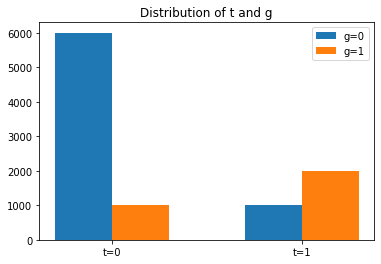

In [ ]:
# Visualize the distribution of the target and protected attributes.
plt.title('Distribution of t and g')
plt.bar(np.arange(2), [np.logical_and(t==0, g==0).sum(), np.logical_and(t==1, g==0).sum()], width=0.3, label='g=0')
plt.bar(np.arange(2)+0.3, [np.logical_and(t==0, g==1).sum(), np.logical_and(t==1, g==1).sum()], width=0.3, label='g=1')
plt.xticks((0.15, 1.15), ('t=0', 't=1'))
plt.legend(loc='best')
plt.show()

In [ ]:
# Split the data into training and validation sets.
train_indices = np.random.choice(10000, size=4000, replace=False)
val_indices = np.random.choice(list(set(np.arange(10000))-set(train_indices)), size=1000, replace=False)
test_indices = np.array(list(set(np.arange(10000)) - set(train_indices) - set(val_indices)))

z_train = z[train_indices]
t_train = t[train_indices]
g_train = g[train_indices]

z_val = z[val_indices]
t_val = t[val_indices]
g_val = g[val_indices]

z_test = z[test_indices]
t_test = t[test_indices]
g_test = g[test_indices]

After creating training, validation, and test splits, you can now train your latent space attribute classifiers $h_t$ and $h_g$ to learn the attributes of $\mathbf{z}$s in the training set. Don't forget to normalize both $\mathbf{w}_t$ and $\mathbf{w}_g$ so that there's a closed-form solution to $\mathbf{z} \mapsto \mathbf{z}'$.

In [ ]:
# Fit a target attribute classifier in the latent space using a linear SVM.
h_t = svm.LinearSVC(max_iter=50000)
h_t.fit(z_train, t_train)

# Normalize so that w_t has norm 1.
w_t_norm = np.linalg.norm(h_t.coef_)
h_t.coef_ = h_t.coef_ / (w_t_norm)  # w_t
h_t.intercept_ = h_t.intercept_ / w_t_norm  # b_t

In [ ]:
# Fit a protected attribute classifier in the latent space using a linear SVM.
h_g = svm.LinearSVC(max_iter=50000) 
h_g.fit(z_train, g_train)

# Normalize so that w_g has norm 1.
w_g_norm = np.linalg.norm(h_g.coef_)
h_g.coef_ = h_g.coef_ / (w_g_norm)
h_g.intercept_ = h_g.intercept_ / w_g_norm

You should then check the accuracy of your trained classifiers to see how well they perform on the validation set.

In [ ]:
# Run inference with h(z) = w^T z + b.
t_val_prediction = np.sum(h_t.coef_ * z_val, axis=1) + h_t.intercept_
g_val_prediction = np.sum(h_g.coef_ * z_val, axis=1) + h_g.intercept_

# Calculate prediction accuracy
t_val_correct = np.logical_and(t_val == 1, t_val_prediction >= 0).sum() + np.logical_and(t_val == 0, t_val_prediction < 0).sum()
g_val_correct = np.logical_and(g_val == 1, g_val_prediction >= 0).sum() + np.logical_and(g_val == 0, g_val_prediction < 0).sum()
print('Accuracy of t classification: {}%'.format(t_val_correct / 1000 * 100))
print('Accuracy of g classification: {}%'.format(g_val_correct / 1000 * 100))

Accuracy of t classification: 98.3%
Accuracy of g classification: 78.5%


Now that you have your trained classifiers, it's now possible to derive the closed form solution to $\mathbf{z}'$. Recall that the equation for this is

\begin{align*}
    \mathbf{z}' = \mathbf{z} - 2\left(\frac{\mathbf{w}_g^T \mathbf{z} +b_g}{1 - (\mathbf{w}_g^T \mathbf{w}_t)^2}\right) \left(\mathbf{w}_g - (\mathbf{w}_g^T \mathbf{w}_t) \mathbf{w}_t \right).
\end{align*}

Note that you can pre-compute some of the terms in this equation that don't depend on $\mathbf{z}$ so that you don't have to re-compute them. Specifically,

\begin{align*}
    \mathbf{w}_{g\perp t} &\triangleq \mathbf{w}_g - (\mathbf{w}_g^T \mathbf{w}_t) \mathbf{w}_t \\
    \sin^2(\angle \mathbf{w}_g\mathbf{w}_t) &\triangleq 1 - (\mathbf{w}_g^T \mathbf{w}_t)^2
\end{align*}

In [ ]:
# Calculate useful information.
g_perp_t = h_g.coef_ - (np.sum(h_g.coef_* h_t.coef_)) * h_t.coef_
g_perp_t = g_perp_t / np.linalg.norm(g_perp_t)
 
cos_theta = np.sum(h_g.coef_ * h_t.coef_)
sin_theta = np.sqrt(1 - cos_theta * cos_theta)  # cos(theta)^2 + sin(theta)^2 = 1
 
# For every z, find z' with flipped protected attribute.
z_prime = np.zeros((5000, 512))
for j in range(5000):
    dist = np.sum(h_g.coef_ * z_test[j]) + h_g.intercept_  # w_g^T z_j + b_g
    z_prime[j] = z_test[j] - ((2 * dist) / sin_theta) * g_perp_t  # closed form solution for z'

Now that you've computed $\mathbf{z}' \in \mathcal{X}_{syn}$ for each $\mathbf{z} \in \mathcal{X}$, you can plot the classifier scores for each $(\mathbf{z}, \mathbf{z}')$ and visualize the distribution of scores across both of your datasets.

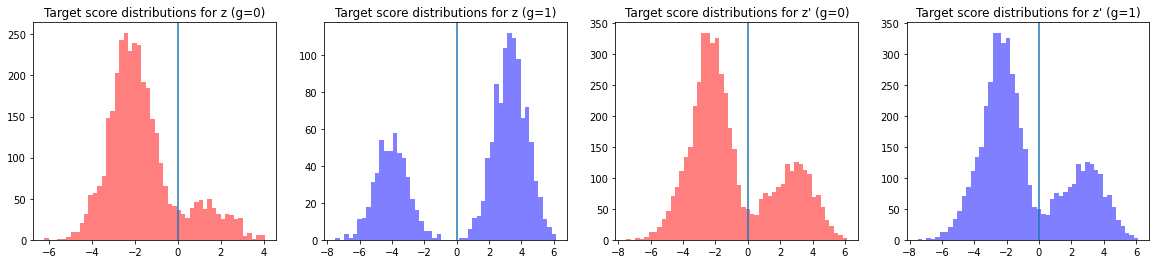

In [ ]:
# Compare target attribute score distributions.
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
 
# Distribution of initial target attribute scores with z.
z_test_g0 = z_test[np.where(g_test == 0)]
z_test_g1 = z_test[np.where(g_test == 1)]
scores_g0 = np.sum(h_t.coef_ * z_test_g0, axis=1) + h_t.intercept_
scores_g1 = np.sum(h_t.coef_ * z_test_g1, axis=1) + h_t.intercept_
 
axs[0].hist(scores_g0, bins=50, color='red', alpha=0.5)
axs[0].axvline(x=0)
axs[0].title.set_text('Target score distributions for z (g=0)')
axs[1].hist(scores_g1, bins=50, color='blue', alpha=0.5)
axs[1].axvline(x=0)
axs[1].title.set_text('Target score distributions for z (g=1)')
 
# Distribution of target attribute scores with z_prime.
z_test_g0 = np.concatenate([z_test[np.where(g_test == 0)], z_prime[np.where(g_test == 1)]])
z_test_g1 = np.concatenate([z_test[np.where(g_test == 1)], z_prime[np.where(g_test == 0)]])
scores_g0 = np.sum(h_t.coef_ * z_test_g0, axis=1) + h_t.intercept_
scores_g1 = np.sum(h_t.coef_ * z_test_g1, axis=1) + h_t.intercept_
 
axs[2].hist(scores_g0, bins=50, color='red', alpha=0.5)
axs[2].axvline(x=0)
axs[2].title.set_text('Target score distributions for z\' (g=0)')
axs[3].hist(scores_g1, bins=50, color='blue', alpha=0.5)
axs[3].axvline(x=0)
axs[3].title.set_text('Target score distributions for z\' (g=1)')
 
plt.show()

On the left, you can see that $\mathbf{z}$'s target attribute score distributions are different for $g=0$ and $g=1$ samples. In contrast, on the right you can see that for $\mathbf{z}'$, the target attribute score distributions are similar for the two protected attribute classes. What the identical distributions for $g$ from $\mathbf{z}'$ means is that even though attributes $(t, g)$ may be correlated to some extent in your original dataset $\mathcal{X}$, your classifier trained on the de-biased $\mathcal{z}'$ does not pick up on any of the correlation.

## Results

Below is a comparison of the classifier trained with $\mathcal{X}$ and $\mathcal{X}_{syn}$ with a baseline model trained on $\mathcal{X}$. The models are evaluated with average precision (AP) and three fairness metrics: difference in equality of opportunity ([DEO](https://papers.nips.cc/paper/2016/hash/9d2682367c3935defcb1f9e247a97c0d-Abstract.html)), bias amplification ([BA](https://arxiv.org/abs/1707.09457)), and KL divergence between score histograms ([KL](http://proceedings.mlr.press/v124/chen20b.html)). Specifically, the authors conduct experiments with 26 (target) attributes in the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. For all experiments, the protected attribute is gender expression. The results are averaged for each target attribute category: inconsistently labeled, gender-dependent, and gender-independent.

The classifier trained with $\mathcal{X}$ and $\mathcal{X}_{syn}$ performs better on all three fairness metrics (DEO, BA, KL) while maintaining comparable AP. The paper contains an in-depth analysis of the method and comparison to existing literature. Their findings show the promise of augmenting data in the GAN latent space in a variety of settings.

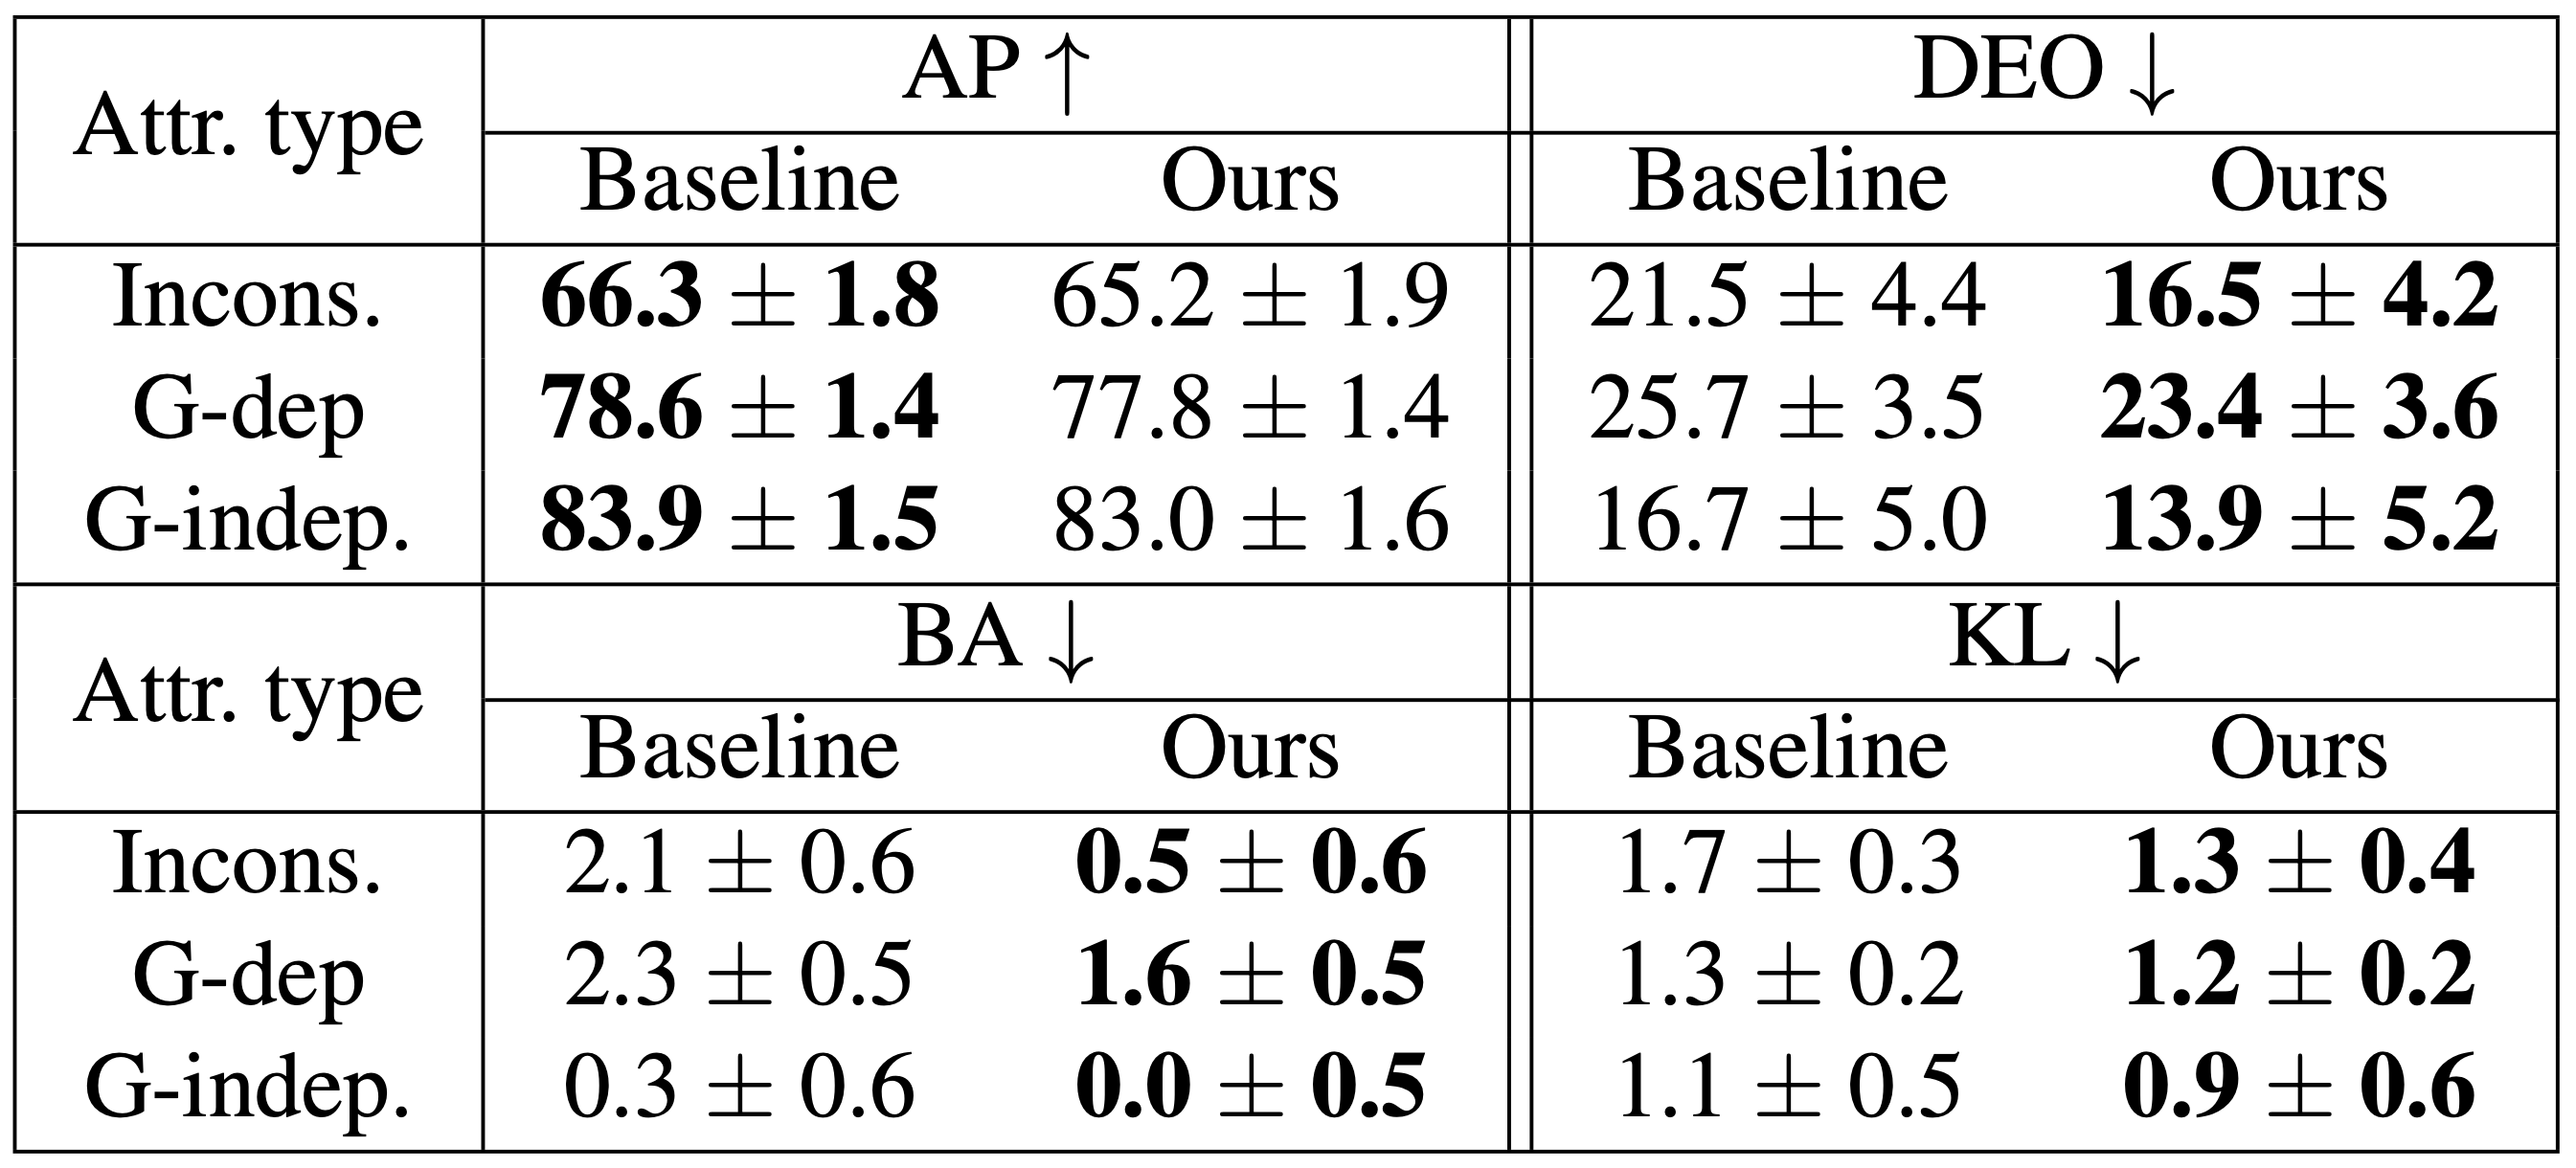

## Discussion

The authors state that the goal of their work is to examine and mitigate biases of sensitive attributes such as gender expression, race, or age in visual classifiers. However, visual manipulations or explicit classifications along these dimensions have the potential to perpetuate harmful stereotypes. Hence for illustrations, they use **wearing glasses** as the protected attribute, as it has a clear visual signal. 

Furthermore, they choose not to show examples of image manipulations. Manipulating images in order to change sensitive attributes is inherently problematic, as it suggests that these attributes can be learned from images and that there is a clear delineation between having and not having the attribute. This is simply not true for multiple reasons. For example, consider the sensitive attribute **gender**. **Gender** is an innate sense of self and is not dependent on presentation. Even considering **gender expression** as the sensitive attribute is flawed (although a little less so) since things that are considered "masculine" are heavily dependent on social and cultural contexts.  Moreover, neither **gender** nor **gender expression** are binary attributes, although they are labeled as such in most present-day image datasets. Finally, generated images are likely to preserve several stereotypes, even if the image generation process tries to eradicate others. For example, images labeled as "masculine" might often have short hair.

For these reasons, they suggest treating the manipulated images as part of the model's learned representation and using them only as an intermediate step for training de-biased attribute classifiers. 

With this in mind, try out their method at [github.com/princetonvisualai/gan-debiasing](https://github.com/princetonvisualai/gan-debiasing)!

